<a href="https://colab.research.google.com/github/giusi07/Sentiment-Analysis-Emotion-Detection/blob/main/Lyrics_Emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resources for report**
- https://stackoverflow.com/questions/55309197/doc2vec-classification-very-poor-results (explain poor doc2vec results)
- https://www.kaggle.com/nitin194/twitter-sentiment-analysis-word2vec-doc2vec (explain choosen classifiers, doc2vec, word2vec)
-https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4 (doc2vec transformation)
- https://datascience.stackexchange.com/questions/19160/why-word2vec-performs-much-worst-than-both-countvectorizer-and-tfidfvectorizer (trained by me word2vec performs worse than tfidf)



# **Future Work/ Items to upload** 
Extend annotated tweets dataset to be able to use deep learning, and exploit better word embedding or better create a human annotated dataset of song lyrics with emotion and genere and train a classifier on that dataset, so that it will be more specific. 

For Git upload:
- train/dev file
- test file
- summary image

# **Libraries**



### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import string
from pprint import pprint
from time import time
import seaborn as sn
import gensim
import tensorflow as tf
from sklearn import utils
import random as python_random
from tqdm import tqdm
import seaborn as sns
import scipy.stats as ss

from sklearn.metrics import accuracy_score, classification_report, f1_score, plot_confusion_matrix, make_scorer, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline


### Install needed libraries

In [2]:
!pip install kaggle

In [3]:
!pip install contractions

     |████████████████████████████████| 286kB 4.9MB/s 
     |████████████████████████████████| 327kB 9.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85384 sha256=902e6a3d9f9c5104506373b63a4d78765105b733024498bb80502c77c3208626
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [4]:
!pip install ekphrasis

     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 184kB 8.8MB/s 
     |████████████████████████████████| 71kB 5.3MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp37-none-any.whl size=82844 sha256=4c7c25f2a9a1415cd8d4cc86109d263cb3b3db8f5f2258929b16d66bd09ced23
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-6.0.1-cp37-none-any.whl size=41573 sha256=49d4233f744c3cec3e03f5b478b14da1019b2b2d6bd86dfd954626580186bdf7
  Stored in directory: /root/.cache/pip/wheels/ae/73/c7/9056e14b04919e5c262fe80b54133b1a88d73683d05d7ac65c
Successfully built ekphrasis ftfy


# **Import Data**
The dataset used to train the classifier, is available at http://saifmohammad.com/WebPages/EmotionIntensity-SharedTask.html.
This dataset is already divided into Train/Dev/Test sets, I use cross-validation the train and development test were merged into a single file

In [5]:
from google.colab import files
uploaded= files.upload()   #load the train_dev.txt, test.txt, files 

Saving test.txt to test.txt
Saving train_dev.txt to train_dev.txt


In [6]:
train= pd.read_csv(io.StringIO(uploaded['train_dev.txt'].decode('utf-8')), sep= '\t', names=["id","text", "emotion", "intensity"])
test= pd.read_csv(io.StringIO(uploaded['test.txt'].decode('utf-8')), sep= '\t', names=["id","text", "emotion", "intensity"])

# **Exploratory Data Analysis**

### **Show dataframes**

In [7]:
train

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896
...,...,...,...,...
3955,40855,Common app just randomly logged me out as I wa...,sadness,0.833
3956,40856,"I'd rather laugh with the rarest genius, in be...",sadness,0.688
3957,40857,If you #invest in my new #film I will stop ask...,sadness,0.458
3958,40858,"Just watched Django Unchained, Other people ma...",sadness,0.333


In [8]:
test

,id,text,emotion,intensity
0,10941,At the point today where if someone says somet...,anger,0.319
1,10942,@CorningFootball IT'S GAME DAY!!!! T MIN...,anger,0.144
2,10943,This game has pissed me off more than any othe...,anger,0.898
3,10944,@spamvicious I've just found out it's Candice ...,anger,0.271
4,10945,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,anger,0.646
...,...,...,...,...
3137,41528,Why does Candice constantly pout #GBBO 💄😒,sadness,0.396
3138,41529,"@redBus_in #unhappy with #redbus CC, when I ta...",sadness,0.604
3139,41530,"@AceOperative789 no pull him afew weeks ago, s...",sadness,0.479
3140,41531,I'm buying art supplies and I'm debating how s...,sadness,0.375


### **Check for null values**

In [9]:
data= [train, test]
for dataset in data:
  print(dataset.isnull().sum())

id           0
text         0
emotion      0
intensity    0
dtype: int64
id           0
text         0
emotion      0
intensity    0
dtype: int64


### **Classes distribution**

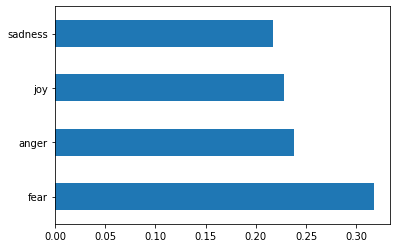

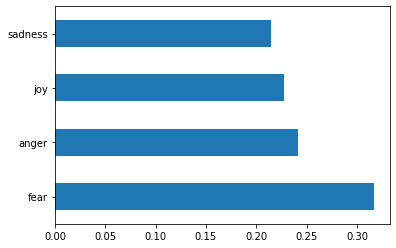

In [10]:
for dataset in data:
  dataset.emotion.value_counts(normalize=True).plot.barh()
  plt.show()

In [11]:
for dataset in data:
  print(dataset['emotion'].value_counts())

fear       1257
anger       941
joy         902
sadness     860
Name: emotion, dtype: int64
fear       995
anger      760
joy        714
sadness    673
Name: emotion, dtype: int64


# **Text Preprocessing**

### **Cleaning**
Ekphrasis is a collection of lightweight text tools, geared towards text from social networks, such as Twitter or Facebook, for tokenization, word normalization, word segmentation (for splitting hashtags) and spell correction, using word statistics from 2 big corpora (english Wikipedia, twitter - 330mil english tweets).

In [12]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

emoticons_extended = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong= True,  # spell correction for elongated words
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, emoticons_extended]
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [13]:
def textPreProcessor(text):
    text = " ".join(text_processor.pre_process_doc(text))
    return text

In [14]:
import contractions
for dataset in data:
   dataset['preprocessed_text'] = dataset['text'].apply(lambda text: contractions.fix(text))
   dataset['preprocessed_text'] = dataset['preprocessed_text'].apply(lambda text: textPreProcessor(text))

### **Tokenize**

In [15]:
from nltk.tokenize import TweetTokenizer

tweetTokenizer = TweetTokenizer()
for dataset in data:
  dataset['tokenized_text']= dataset['preprocessed_text'].apply(lambda text: tweetTokenizer.tokenize(text))

### **Removing punctuation**
In this case, since we are dealing with tweets I do not remove stopwords, because this would reduce too much the text and could decrease performances according to https://www.aclweb.org/anthology/L14-1265/[testo del link](https://)

In [16]:
def remove_punctuation(tokens):
    return [token for token in tokens if token not in string.punctuation]
    

In [17]:
for dataset in data:
  dataset['tokenized_text']= dataset['tokenized_text'].apply(lambda text: remove_punctuation(text))

In [18]:
train

,id,text,emotion,intensity,preprocessed_text,tokenized_text
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,how the fu*k <censored> ! who the heck ! moved...,"[how, the, fu, k, <censored>, who, the, heck, ..."
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,so my indian uber driver just called someone t...,"[so, my, indian, uber, driver, just, called, s..."
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,<user> i asked for my parcel to be delivered t...,"[<user>, i, asked, for, my, parcel, to, be, de..."
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,so ef whichever butt wipe pulled the fire alar...,"[so, ef, whichever, butt, wipe, pulled, the, f..."
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,do not join <user> they put the phone down on ...,"[do, not, join, <user>, they, put, the, phone,..."
...,...,...,...,...,...,...
3955,40855,Common app just randomly logged me out as I wa...,sadness,0.833,common app just randomly logged me out as i wa...,"[common, app, just, randomly, logged, me, out,..."
3956,40856,"I'd rather laugh with the rarest genius, in be...",sadness,0.688,"i would rather laugh with the rarest genius , ...","[i, would, rather, laugh, with, the, rarest, g..."
3957,40857,If you #invest in my new #film I will stop ask...,sadness,0.458,if you <hashtag> invest </hashtag> in my new <...,"[if, you, <hashtag>, invest, </hashtag>, in, m..."
3958,40858,"Just watched Django Unchained, Other people ma...",sadness,0.333,"just watched django unchained , other people m...","[just, watched, django, unchained, other, peop..."


### **Split data**
Separate between tokenized text and the emotion label

In [19]:
X_train= train['tokenized_text']
y_train= train['emotion']
X_test= test['tokenized_text']
y_test= test['emotion']

### **Encode Emotions' labels**

In [20]:
from sklearn import preprocessing

labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(["anger", "fear", "joy", "sadness"])

#encode labels
y_train= labelEncoder.transform(y_train)
y_test= labelEncoder.transform(y_test)

#reverse labeling
#labelEncoder.inverse_transform(array)

# **Baseline**


In [21]:
#pass function for  the pipeline since the text is already tokenized
def dummy(text):
    return text

In [22]:
def gridsearch(pipeline, parameters, X_train, y_train):
  if __name__ == "__main__":
    
    
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring= 'f1_weighted')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters: \n")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("Executed in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return grid_search

In [23]:
def modelevaluation(model, X_test, y_test, xgb):
  if xgb:
    preds = model.predict(X_test)
    y_pred = np.asarray([np.argmax(line) for line in preds])
  else: 
    y_pred = model.predict(X_test)
    
  print("Test Classification Report")
  print(classification_report(y_test, y_pred))
  print("Balanced test accuracy: ", round(balanced_accuracy_score(y_test, y_pred),3))


In [24]:
def confusionMatrix(model=None, modelname=None, X_test=None, y_test=None, xgb=None, y_true=None, y_pred=None):
  normalize=['true', None]

  if xgb:
    for n in normalize:
      if n == 'true':
        array= confusion_matrix(y_true, y_pred, normalize=n)
        df_cm = pd.DataFrame(array, index=['anger', 'fear', 'joy', 'sadness'] , columns= ['anger', 'fear', 'joy', 'sadness'] )
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, cmap=plt.cm.Blues ) 
        plt.text(-1,-1, s= modelname + " - Test Confusion Matrix with Normalization", fontsize=12)
        plt.show()
      else:
        array= confusion_matrix(y_true, y_pred, normalize=n)
        df_cm = pd.DataFrame(array, index=['anger', 'fear', 'joy', 'sadness'] , columns= ['anger', 'fear', 'joy', 'sadness'] )
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, cmap=plt.cm.Blues ) 
        plt.text(-1,-1, s= modelname +  " - Test Confusion Matrix without Normalization", fontsize=12)
        plt.show()

  else:
      for n in normalize:
        plot_confusion_matrix(model, X_test, y_test, display_labels= labelEncoder.classes_,
                                 cmap=plt.cm.Blues, normalize= n)
        if n== 'true':
          plt.text(-1,-1, s= modelname + " - Test Confusion Matrix with Normalization")
        else:
          plt.text(-1,-1, s= modelname +  " - Test Confusion Matrix without Normalization")
      plt.show()


## **Multinomial Naive Bayes**

In [25]:
from sklearn.naive_bayes import MultinomialNB
pipeline = Pipeline([
    ('vect', CountVectorizer(preprocessor=dummy, tokenizer=dummy)),
    ('tfidf', TfidfTransformer()),
    ('clf',  MultinomialNB()),
])

parameters = {
    'clf__alpha': [0.01, 0.1, 0.2, 0.3, 1],
}

model_nb= gridsearch(pipeline=pipeline, parameters=parameters, X_train= X_train, y_train= y_train)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__alpha': [0.01, 0.1, 0.2, 0.3, 1]}
Executed in 2.228s

Best score: 0.740
Best parameters set:
	clf__alpha: 0.2


### Model Evaluation

In [26]:
modelevaluation(model=model_nb, X_test=X_test, y_test=y_test, xgb=False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       760
           1       0.64      0.84      0.73       995
           2       0.83      0.67      0.74       714
           3       0.69      0.59      0.64       673

    accuracy                           0.71      3142
   macro avg       0.73      0.70      0.71      3142
weighted avg       0.73      0.71      0.71      3142

Balanced test accuracy:  0.7


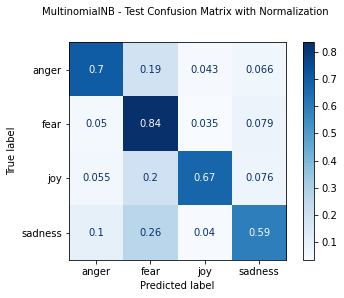

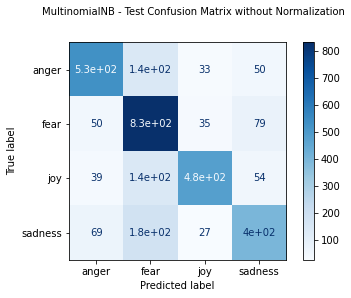

In [27]:
confusionMatrix(model=model_nb, modelname='MultinomialNB', X_test=X_test, y_test=y_test)

The 5-fold cross validated training f1_weighted score is 74%, while the test f1_weighted score is 71%, this score is not very high and in the next sections I try to use different algorithms and embeddings techniques to try to improve this result; thus this model is our baseline.

Since the data is slightly imbalanced the model performed better in the class that is most represented "fear", while it performed worse on those that are least represented: "sadness" and "joy"

The confusion matrix shows that:
- "anger" is misinterpreted as "fear" 
- "joy" is misinterpreted as "fear"
- "sadness" is misinterpeted as "fear" <br>
Therefore all emotions are mostly misinterpeted as "fear", this is also shown in the report where precision and recall are respecivily equal to 0.64 and 0.84

# **Models**

## **1. TF-IDF**




### **Support Vector Machine** 

In [28]:
from sklearn.svm import SVC

pipeline = Pipeline([
    ('vect', CountVectorizer(preprocessor=dummy, tokenizer=dummy)),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf',  SVC()),
])

parameters = {'clf__kernel': ['rbf'], 'clf__gamma': [1e-3, 1e-4],
                     'clf__C': [0.1, 1, 10, 100, 1000]
}

model_svc= gridsearch(pipeline=pipeline, parameters=parameters, X_train= X_train, y_train= y_train)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100, 1000],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['rbf']}
Executed in 172.684s

Best score: 0.811
Best parameters set:
	clf__C: 1000
	clf__gamma: 0.001
	clf__kernel: 'rbf'


#### Model Evaluation

In [29]:
modelevaluation(model=model_svc, X_test=X_test, y_test=y_test, xgb= False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.79      0.74      0.77       760
           1       0.76      0.80      0.77       995
           2       0.85      0.81      0.83       714
           3       0.73      0.75      0.74       673

    accuracy                           0.78      3142
   macro avg       0.78      0.78      0.78      3142
weighted avg       0.78      0.78      0.78      3142

Balanced test accuracy:  0.776


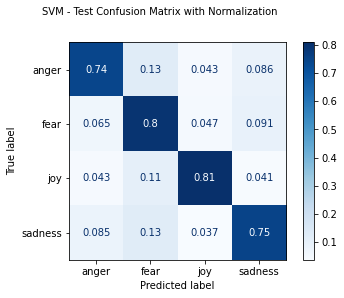

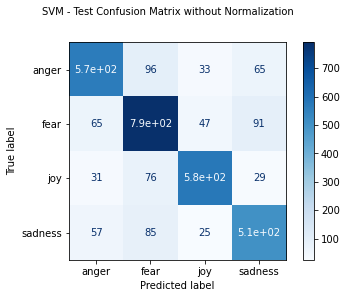

In [30]:
confusionMatrix(model=model_svc, modelname='SVM', X_test=X_test, y_test=y_test)

The 5-fold cross validated training f1_weighted score is 81%, while the test f1_weighted score is 78%, the model performs much better compared to multinomialNB (+7% of accuracy) probably because SVM looks at the interactions  to a certain degree when a non linear kernel is used as "rbf" in this case. Since the context of the tweet is important to understand the type of emotion expressed, in this case, the approach of SVM is betters suited. 

Moreover, unlike MultinomialNB, this model is less affected by the imbalances of the dataset, indeed the "sadness" is classified correctly (0.75 recall) compared to "anger" (0.74 recall) even if "sadness" is less represented than "anger"

 

### **XGBOOST**

In [31]:
import xgboost as xgb

pipeline = Pipeline([
    ('vect', CountVectorizer(preprocessor=dummy, tokenizer=dummy)),
    ('tfidf', TfidfTransformer()),
    ('clf',  xgb.XGBClassifier(objective= 'multi:softprob', num_class=4, eta=0.03)),
])

parameters = {
     "clf__max_depth"        : [ 3, 4, 10],
     "clf__min_child_weight" : [ 1, 3],
     "clf__gamma"            : [ 0.1, 0.5]
     }

model_xgb= gridsearch(pipeline=pipeline, parameters=parameters, X_train= X_train, y_train= y_train)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__gamma': [0.1, 0.5],
 'clf__max_depth': [3, 4, 10],
 'clf__min_child_weight': [1, 3]}
Executed in 605.272s

Best score: 0.821
Best parameters set:
	clf__gamma: 0.1
	clf__max_depth: 10
	clf__min_child_weight: 1


#### Model Evaluation

In [32]:
modelevaluation(model=model_xgb, X_test=X_test, y_test=y_test, xgb= False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       760
           1       0.72      0.90      0.80       995
           2       0.93      0.84      0.88       714
           3       0.83      0.78      0.81       673

    accuracy                           0.82      3142
   macro avg       0.85      0.82      0.83      3142
weighted avg       0.84      0.82      0.82      3142

Balanced test accuracy:  0.817


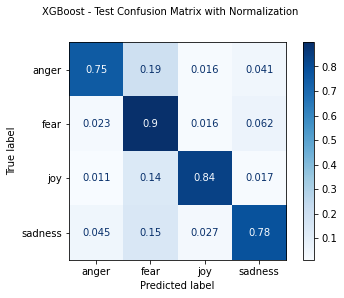

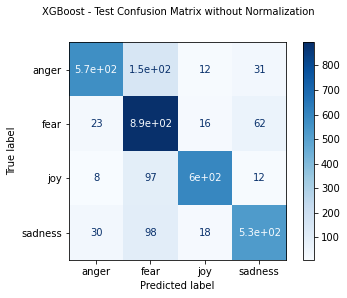

In [33]:
confusionMatrix(model=model_xgb, modelname='XGBoost', X_test=X_test, y_test=y_test)

The 5-fold cross validated training f1_weighted score is 82%, and also the test f1_weighted score is 82%. Therefore,  the model performs much better compared to multinomialNB (+11%) and better than SVM (+4%).

However, this model is more affected by the imbalances of the dataset, indeed also in this case all classes are mostly misinterpeted as "fear". 

## **2. Doc2Vec models**

In [34]:
from gensim.models.doc2vec import TaggedDocument

#tag documents with their emotion label
train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokenized_text'], tags=[r.emotion]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokenized_text'], tags=[r.emotion]), axis=1)


In [35]:
import multiprocessing
from gensim.models import Doc2Vec

cores = multiprocessing.cpu_count()

#train doc2vec model
model_dbow = Doc2Vec(dm=0, vector_size=1000, negative=5, hs=0, min_count=2, sample = 0, workers=cores, seed=42)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])


for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 3960/3960 [00:00<00:00, 527451.38it/s]


In [36]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [37]:
#extract vectors
y_train_doc, X_train_doc = vec_for_learning(model_dbow, train_tagged)
y_test_doc, X_test_doc = vec_for_learning(model_dbow, test_tagged)

### **Support Vector Machine** 

In [38]:
from sklearn.svm import SVC

model_svc_doc = SVC(C=1000, gamma=0.001, kernel= 'rbf')
model_svc_doc.fit(X_train_doc, y_train_doc)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [39]:
scores = cross_val_score(model_svc_doc, X_train_doc, y_train_doc, cv=5, scoring='f1_weighted')
print("Cross validation f1-score: ", round(scores.mean(), 3))

Cross validation f1-score:  0.271


#### Model Evaluation

In [40]:
modelevaluation(model=model_svc_doc, X_test=X_test_doc, y_test=y_test_doc, xgb=False)

Test Classification Report
              precision    recall  f1-score   support

       anger       0.31      0.18      0.23       760
        fear       0.33      0.79      0.46       995
         joy       0.33      0.14      0.20       714
     sadness       0.00      0.00      0.00       673

    accuracy                           0.33      3142
   macro avg       0.24      0.28      0.22      3142
weighted avg       0.26      0.33      0.25      3142

Balanced test accuracy:  0.278


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


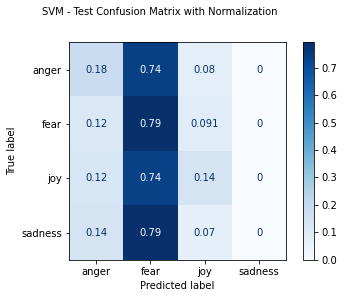

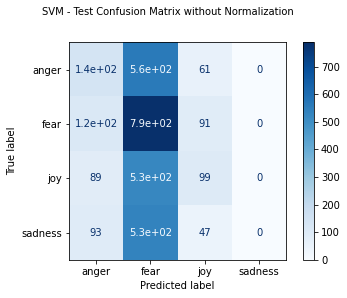

In [41]:
confusionMatrix(model=model_svc_doc, modelname='SVM', X_test=X_test_doc, y_test=y_test_doc)

The 5-fold cross validated training f1_weighted score is 29%, while the test f1_weighted score is 25%. This shows that the model performs very bad, with an accuracy that is practically the same that we would obtain with a random guess. Moreover the confusion matrix shows that most documents are classified with the label "fear". This is most likely due to the fact that the doc2vec embedding captured more the pattern of documents classified with the emotion "fear" since it is the class that is most represented in the dataset, indeed the class "sadness" which is the least represented in the dataset, is the worst predicted one.

This suggests that the doc2vec embedding might not be suited for this type of dataset, where some classes are more represented than others.
But the main issue might be that the dataset is too small (indeed there are less than 4000 documents) to train the doc2vec model appropriately. 


### **XGBOOST**

In [42]:
import xgboost as xgb

D_train = xgb.DMatrix(np.matrix(X_train_doc), label=y_train)
D_test = xgb.DMatrix(np.matrix(X_test_doc), label=y_test)

In [43]:
param = {'gamma': 0.1,
    'eta': 0.3,  
    'objective': 'multi:softprob',  
    'num_class': 4,
    'max_depth': 10,
	  'min_child_weight': 1} 
   
steps = 20  
model_xgb_doc = xgb.train(param, D_train, steps)
preds = model_xgb_doc.predict(D_test)
y_pred = np.asarray([np.argmax(line) for line in preds])

#### Model Evaluation

In [44]:
modelevaluation(model=model_xgb_doc, X_test=D_test, y_test=y_test, xgb=True)

Test Classification Report
              precision    recall  f1-score   support

           0       0.28      0.23      0.26       760
           1       0.34      0.45      0.38       995
           2       0.27      0.24      0.25       714
           3       0.22      0.19      0.21       673

    accuracy                           0.29      3142
   macro avg       0.28      0.28      0.27      3142
weighted avg       0.28      0.29      0.29      3142

Balanced test accuracy:  0.277


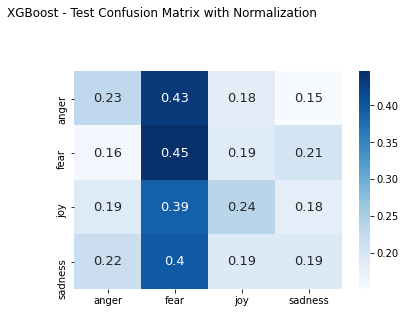

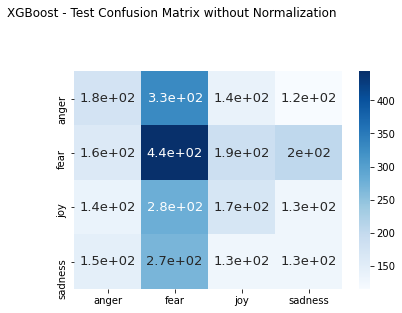

In [45]:
confusionMatrix(y_true=y_test, y_pred=y_pred, modelname= 'XGBoost', xgb=True)

Also with XGBoost the document embedding yields very poor results, and also in this case, as shown in the confusion matrix, most documents are classifed with the label "fear". 

## **3. Custom Word2Vec Models** 
Train a Word2Vec model on my dataset and use obtained vectors to embedd documents, using 2 strategies: <br>
**1. Averaged Embedding**: embedd each document by taking the average of the vectors of the words contained in the document <br>
**2. TfIdf Weighted Embedding**: embedd each document by taking a weighted average of the vectors of the words contained in the document, by using as weight the
 TfIdf score of that word 

In [46]:
#merge train and test set to train word2vec model
data = pd.concat([X_train, X_test], axis=0).reset_index()
data= data['tokenized_text']

In [47]:
from gensim.models import Word2Vec
model_w2v = gensim.models.Word2Vec(
            data,
            size=200, 
            window=5, 
            min_count=2,                                 
            sg = 1, # skip-gram model
            hs = 0,
            negative = 10, 
            workers= 32,
            seed = 34) 

model_w2v.train(data, total_examples= len(data), epochs=20)

(1895802, 2809880)

### Averaged Embedding

In [48]:
#Transfor document into w2v embedding by taking average of vectors of words in the document
def word_vector_average(tokens, size, model):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

def transformData_average(data, size, model):
  w2v = np.zeros((len(data), size)) 
  for i in range(len(data)):
    w2v[i,:] = word_vector_average(data[i], size, model)
  
  return w2v

In [49]:
transformedTrain= transformData_average(X_train, 200, model_w2v)
X_train_w2v = pd.DataFrame(transformedTrain)

transformedTest= transformData_average(X_test, 200, model_w2v)
X_test_w2v = pd.DataFrame(transformedTest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


#### **Support Vector Machine** 

In [50]:
from sklearn.svm import SVC

model_svc_w2v = SVC(C=1000, gamma=0.001, kernel= 'rbf')
model_svc_w2v.fit(X_train_w2v, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [51]:
kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
scores = cross_val_score(model_svc_w2v, X_train_w2v, y_train, cv=kFold, scoring='f1_weighted')
print("Cross validation f1-score: ", round(scores.mean(), 2))

Cross validation f1-score:  0.54


##### Model Evaluation

In [52]:
modelevaluation(model=model_svc_w2v, X_test=X_test_w2v, y_test=y_test, xgb=False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.53      0.49      0.51       760
           1       0.53      0.65      0.58       995
           2       0.61      0.55      0.58       714
           3       0.47      0.41      0.44       673

    accuracy                           0.54      3142
   macro avg       0.54      0.52      0.53      3142
weighted avg       0.54      0.54      0.53      3142

Balanced test accuracy:  0.524


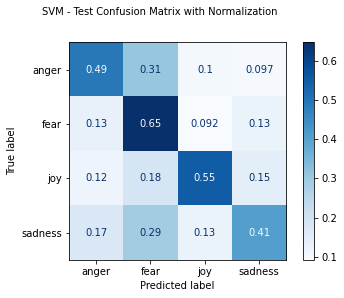

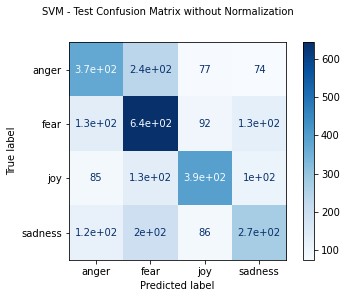

In [53]:
confusionMatrix(model=model_svc_w2v, modelname='SVM', X_test=X_test_w2v, y_test=y_test)

#### **XGBOOOST**

In [54]:
 import xgboost as xgb
 model_xgb_w2v= xgb.XGBClassifier(objective= 'multi:softprob', num_class=4, eta=0.03, gamma= 0.1, max_depth= 10, min_child_weight=1)
 model_xgb_w2v.fit(X_train_w2v, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [55]:
scores = cross_val_score(model_xgb_w2v, X_train_w2v, y_train, cv=5, scoring='f1_weighted')
print("Cross validation f1-score: ", round(scores.mean(), 3))

Cross validation f1-score:  0.536


##### Model Evaluation

In [56]:
modelevaluation(model=model_xgb_w2v, X_test=X_test_w2v, y_test=y_test, xgb=False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.44      0.41      0.43       760
           1       0.48      0.60      0.53       995
           2       0.58      0.52      0.55       714
           3       0.35      0.28      0.31       673

    accuracy                           0.47      3142
   macro avg       0.46      0.45      0.46      3142
weighted avg       0.47      0.47      0.46      3142

Balanced test accuracy:  0.454


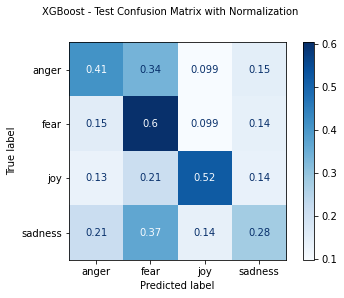

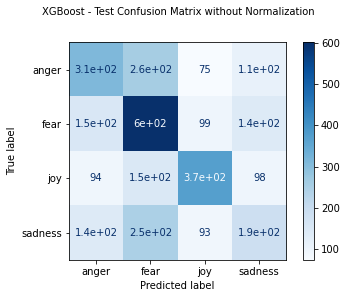

In [57]:
confusionMatrix(model=model_xgb_w2v, modelname='XGBoost', X_test=X_test_w2v, y_test=y_test)

The Word2Vec embedding did not improve performances of either model, not SVM nor XGBoost, in the first case the test f1-weighted score is 54% whereas in the second case the score is 46%. This is most likely due to the fact that the dataset used to train the Word2Vec model is too small, and therefore it is uncapable of capturing most of the relationships between words, ending up with poor performances. 

### TF-IDF Weighted Embedding

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(tokenizer= dummy, stop_words=None, lowercase= False)
final_tf_idf = tf_idf_vect.fit_transform(data)
tfidf_feat = tf_idf_vect.get_feature_names()

In [59]:
def word_vector_tfidfweighted(tokens, size, model):
    sent_vec = np.zeros(size).reshape((1, size))
    row=0
    weight_sum =0;
    for word in tokens:
        try:
            vec = model[word].reshape((1, size))
            tfidf = final_tf_idf[0, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if weight_sum != 0:
        sent_vec /= weight_sum
    row +=1
    return sent_vec

def transformData_tfidf(data, size, model):
  w2v = np.zeros((len(data), size)) 
  for i in range(len(data)):
    w2v[i,:] = word_vector_tfidfweighted(data[i], size, model)
  
  return w2v

In [60]:
transformedTrain_tfidf= transformData_tfidf(X_train, 200, model_w2v)
X_train_w2v_tfidf = pd.DataFrame(transformedTrain_tfidf)

transformedTest_tfidf= transformData_tfidf(X_test, 200, model_w2v)
X_test_w2v_tfidf = pd.DataFrame(transformedTest_tfidf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


#### **Support Vector Machine**

In [61]:
from sklearn.svm import SVC

model_svc_w2v_tfidf = SVC(C=1000, gamma=0.001, kernel= 'rbf')
model_svc_w2v_tfidf.fit(X_train_w2v_tfidf, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [62]:
scores = cross_val_score(model_svc_w2v_tfidf, X_train_w2v_tfidf, y_train, cv=5, scoring='f1_weighted')
print("Cross validation f1-score: ", round(scores.mean(), 3))

Cross validation f1-score:  0.213


##### Model Evaluation

In [63]:
modelevaluation(model=model_svc_w2v_tfidf, X_test=X_test_w2v_tfidf, y_test=y_test, xgb=False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.46      0.10      0.16       760
           1       0.32      0.96      0.48       995
           2       0.38      0.01      0.01       714
           3       0.14      0.00      0.00       673

    accuracy                           0.33      3142
   macro avg       0.33      0.27      0.17      3142
weighted avg       0.33      0.33      0.20      3142

Balanced test accuracy:  0.266


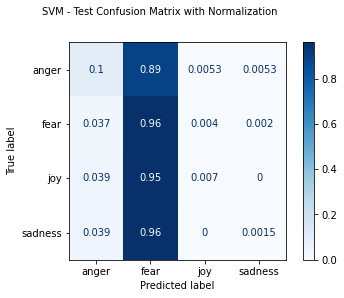

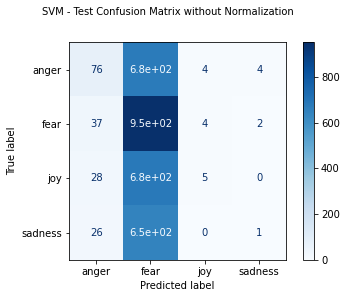

In [64]:
confusionMatrix(model=model_svc_w2v_tfidf, modelname='SVM', X_test=X_test_w2v_tfidf, y_test=y_test)

#### **XGBOOOST**

In [65]:
 import xgboost as xgb
 model_xgb_w2v_tfidf= xgb.XGBClassifier(objective= 'multi:softprob', num_class=4, eta=0.03, gamma= 0.1, max_depth= 10, min_child_weight=1)
 model_xgb_w2v_tfidf.fit(X_train_w2v_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [66]:
kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_xgb_w2v_tfidf, X_train_w2v_tfidf, y_train, cv=kFold, scoring='f1_weighted')
print("Cross validation f1-score: ", round(scores.mean(), 3))

Cross validation f1-score:  0.248


##### Model Evaluation

In [67]:
modelevaluation(model=model_xgb_w2v_tfidf, X_test=X_test_w2v_tfidf, y_test=y_test, xgb=False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.30      0.20      0.24       760
           1       0.33      0.75      0.46       995
           2       0.22      0.06      0.09       714
           3       0.25      0.08      0.12       673

    accuracy                           0.31      3142
   macro avg       0.28      0.27      0.23      3142
weighted avg       0.28      0.31      0.25      3142

Balanced test accuracy:  0.27


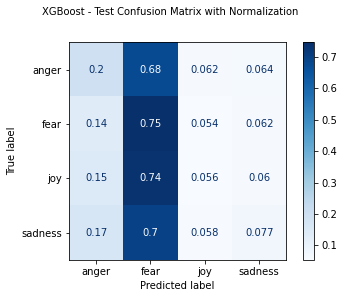

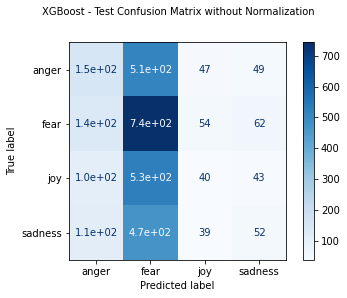

In [68]:
confusionMatrix(model=model_xgb_w2v_tfidf, modelname='XGBoost', X_test=X_test_w2v_tfidf, y_test=y_test)

The TF-IDF weighting of the word embedding vectors, makes results even worse, most likely due to the fact that the word embedding model is trained on a small dataset with a poor outcome, which is even more emphatized when weighting for tf-idf scores of the words, thus resulting into lower f1-weighted test score: equal to 20% for SVM and 25% for XGBoost.

## **4. Pre-Trained Word2Vec Models**
In order to overcome the problem of Word2Vec model trained over a small dataset, I try to use a pretrained model over twitter, however there is the risk that this might be too generic with respect to emotions. 

In [121]:
import gensim.downloader as api
#download pre-trained model over tweets with embeddings of size 200
word_vectors = api.load("glove-twitter-200")

[==================================================] 100.0% 758.5/758.5MB downloaded


### Averaged Embedding

In [122]:
transformedTrain_pretrained= transformData_average(X_train, 200, word_vectors)
X_train_w2v_pretrained = pd.DataFrame(transformedTrain_pretrained)

transformedTest_pretrained= transformData_average(X_test, 200, word_vectors)
X_test_w2v_pretrained = pd.DataFrame(transformedTest_pretrained)

#### **Support Vector Machine** 

In [123]:
from sklearn.svm import SVC

model_svc_w2v_pretrained = SVC(C=1000, gamma=0.001, kernel= 'rbf')
model_svc_w2v_pretrained.fit(X_train_w2v_pretrained, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [124]:
kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_svc_w2v_pretrained, X_train_w2v_pretrained, y_train, cv=kFold, scoring='f1_weighted')
print("Cross validation f1-score: ", round(scores.mean(), 3))

Cross validation f1-score:  0.63


##### Model Evaluation

In [125]:
modelevaluation(model=model_svc_w2v_pretrained, X_test=X_test_w2v_pretrained, y_test=y_test, xgb=False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       760
           1       0.64      0.65      0.64       995
           2       0.70      0.68      0.69       714
           3       0.59      0.54      0.56       673

    accuracy                           0.63      3142
   macro avg       0.63      0.62      0.62      3142
weighted avg       0.63      0.63      0.63      3142

Balanced test accuracy:  0.623


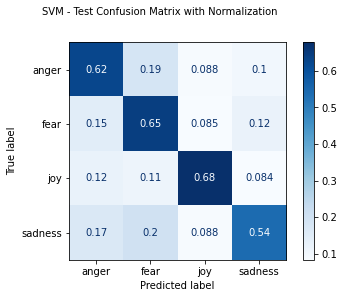

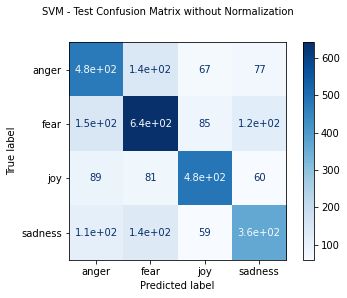

In [126]:
confusionMatrix(model=model_svc_w2v_pretrained, modelname='SVM', X_test=X_test_w2v_pretrained, y_test=y_test)

#### **XGBOOOST**

In [127]:
 import xgboost as xgb
 model_xgb_w2v_pretrained= xgb.XGBClassifier(objective= 'multi:softprob', num_class=4, eta=0.03, gamma= 0.1, max_depth= 10, min_child_weight=1)
 model_xgb_w2v_pretrained.fit(X_train_w2v_pretrained, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [128]:
scores = cross_val_score(model_xgb_w2v_pretrained, X_train_w2v_pretrained, y_train, cv=5, scoring='f1_weighted')
print("Cross validation f1-score: ", round(scores.mean(), 3))

Cross validation f1-score:  0.562


##### Model Evaluation

In [129]:
modelevaluation(model=model_xgb_w2v_pretrained, X_test=X_test_w2v_pretrained, y_test=y_test, xgb=False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.54      0.51      0.53       760
           1       0.53      0.63      0.57       995
           2       0.62      0.58      0.60       714
           3       0.44      0.37      0.40       673

    accuracy                           0.53      3142
   macro avg       0.53      0.52      0.52      3142
weighted avg       0.53      0.53      0.53      3142

Balanced test accuracy:  0.522


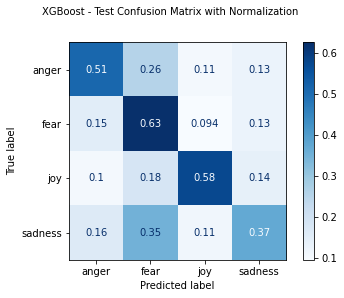

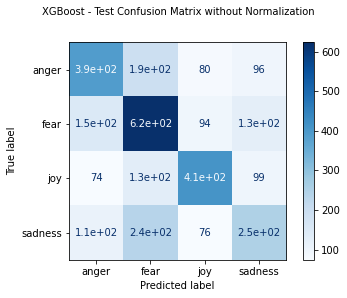

In [130]:
confusionMatrix(model=model_xgb_w2v_pretrained, modelname='XGBoost', X_test=X_test_w2v_pretrained, y_test=y_test)

The Word2Vec embedding with the pretrained model slightly improved performances of both models, SVM and XGBoost, with respect to the self-trained Word2Vec model: indeed, in the first case the test f1-weighted score is 63% whereas in the second case the score is 53%. This indeed confirms the idea that the Word2Vec model trained on the dataset was not capable of capturing most of the information since the corpuse is too small, results instead improve with pre-trained model.

### TF-IDF Weighted Embedding

In [131]:
transformedTrain_tfidf_pretrained= transformData_tfidf(X_train, 200, word_vectors)
X_train_w2v_tfidf_pretrained = pd.DataFrame(transformedTrain_tfidf_pretrained)

transformedTest_tfidf_pretrained= transformData_tfidf(X_test, 200, word_vectors)
X_test_w2v_tfidf_pretrained = pd.DataFrame(transformedTest_tfidf_pretrained)

#### **Support Vector Machine**

In [132]:
from sklearn.svm import SVC

model_svc_w2v_tfidf_pretrained = SVC(C=1000, gamma=0.001, kernel= 'rbf')
model_svc_w2v_tfidf_pretrained.fit(X_train_w2v_tfidf_pretrained, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [133]:
scores = cross_val_score(model_svc_w2v_tfidf_pretrained, X_train_w2v_tfidf_pretrained, y_train, cv=5, scoring='f1_weighted')
print("Cross validation f1-score: ", round(scores.mean(), 3))

Cross validation f1-score:  0.215


##### Model Evaluation

In [134]:
modelevaluation(model=model_svc_w2v_tfidf_pretrained, X_test=X_test_w2v_tfidf_pretrained, y_test=y_test, xgb=False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.45      0.11      0.17       760
           1       0.32      0.95      0.48       995
           2       0.31      0.01      0.01       714
           3       0.11      0.00      0.01       673

    accuracy                           0.33      3142
   macro avg       0.30      0.27      0.17      3142
weighted avg       0.30      0.33      0.20      3142

Balanced test accuracy:  0.266


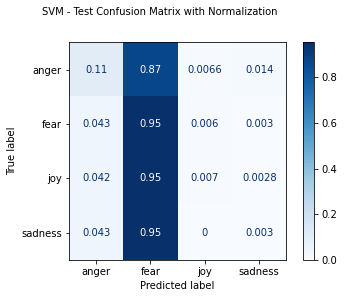

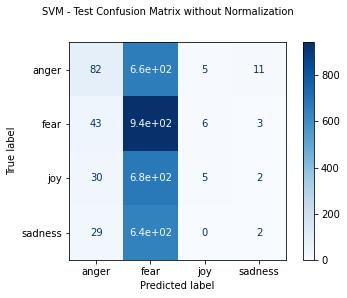

In [135]:
confusionMatrix(model=model_svc_w2v_tfidf_pretrained, modelname='SVM', X_test=X_test_w2v_tfidf_pretrained, y_test=y_test)

#### **XGBOOOST**

In [136]:
 import xgboost as xgb
 model_xgb_w2v_tfidf_pretrained= xgb.XGBClassifier(objective= 'multi:softprob', num_class=4, eta=0.03, gamma= 0.1, max_depth= 10, min_child_weight=1)
 model_xgb_w2v_tfidf_pretrained.fit(X_train_w2v_tfidf_pretrained, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [137]:
scores = cross_val_score(model_xgb_w2v_tfidf_pretrained, X_train_w2v_tfidf_pretrained, y_train, cv=5, scoring='f1_weighted')
print("Cross validation f1-score: ", round(scores.mean(), 3))

Cross validation f1-score:  0.245


##### Model Evaluation

In [138]:
modelevaluation(model=model_xgb_w2v_tfidf_pretrained, X_test=X_test_w2v_tfidf_pretrained, y_test=y_test, xgb=False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.31      0.17      0.22       760
           1       0.33      0.82      0.47       995
           2       0.22      0.03      0.05       714
           3       0.25      0.05      0.09       673

    accuracy                           0.32      3142
   macro avg       0.28      0.27      0.21      3142
weighted avg       0.28      0.32      0.23      3142

Balanced test accuracy:  0.269


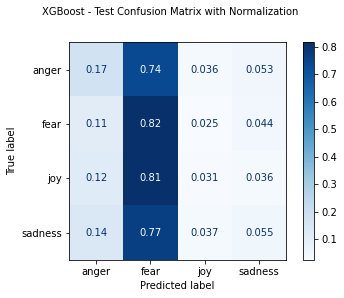

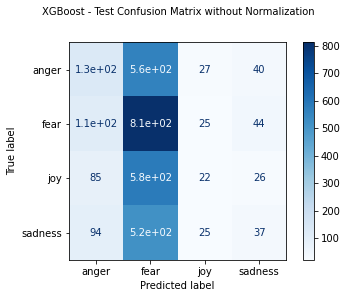

In [139]:
confusionMatrix(model=model_xgb_w2v_tfidf_pretrained, modelname='XGBoost', X_test=X_test_w2v_tfidf_pretrained, y_test=y_test)

The TF-IDF weighting with the pretrained word embedding are slightly better than the ones with the trained model, but the TFIDF weighting compared to the average of embedding makes results worse. This is most likely due to the fact that the model, being pre-trained, captures context information that are not specific to emotion expression, and this difference is emphatized by the tfidf score. Therefore, although the pre-trained model works better than the self-trained one is not domain specific so it does not help performances to improve

# **Models Summary**
Since, the goal of this project is to create a classifier to apply to another dataset, which is made of song lyrics, the choice between all the models evaluated in the previous sections will be made based on the f1-weighted test score, to make sure to select the model that has the highest test performances and thus that has the best chance at performing well on a different dataset. 

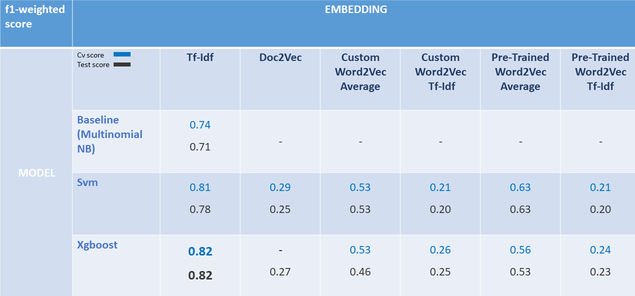

# **Song Lyrics**

## Load dataset from Kaggle

In [71]:
#upload Kaggle Token
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [72]:
!kaggle datasets download -d neisse/scrapped-lyrics-from-6-genres

 86% 65.0M/75.8M [00:00<00:00, 93.5MB/s]
100% 75.8M/75.8M [00:00<00:00, 129MB/s] 


In [73]:
!unzip scrapped-lyrics-from-6-genres

Archive:  scrapped-lyrics-from-6-genres.zip
  inflating: artists-data.csv        
  inflating: lyrics-data.csv         


In [74]:
artists= pd.read_csv('artists-data.csv')
artists= artists.drop(columns=['Songs', 'Popularity', 'Genres'])
artists.head()

,Artist,Link,Genre
0,10000 Maniacs,/10000-maniacs/,Rock
1,12 Stones,/12-stones/,Rock
2,311,/311/,Rock
3,4 Non Blondes,/4-non-blondes/,Rock
4,A Cruz Está Vazia,/a-cruz-esta-vazia/,Rock


In [75]:
lyrics = pd.read_csv('lyrics-data.csv')
lyrics.head()

,ALink,SName,SLink,Lyric,Idiom
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH


## Explore Dataset

#### Language

This dataset contains English song lyrics but also lyrics written in other languages. For the purpose of this project, only English lyrics will be retained since the Emotion classifier has been trained on english documents.

In [76]:
lyrics.Idiom.value_counts() #check languages

ENGLISH           114723
PORTUGUESE         85085
SPANISH             4812
ITALIAN              626
FRENCH               471
GERMAN               314
KINYARWANDA           88
ICELANDIC             47
SWEDISH               27
FINNISH               24
INDONESIAN            17
GALICIAN              12
ESTONIAN              12
IRISH                  9
DANISH                 9
HAITIAN_CREOLE         9
BASQUE                 8
NORWEGIAN              7
TAGALOG                7
CROATIAN               7
SUNDANESE              6
CATALAN                6
SWAHILI                5
DUTCH                  5
MALAY                  4
RUSSIAN                4
SERBIAN                3
SESOTHO                2
MALAGASY               2
NYANJA                 2
TURKISH                2
JAPANESE               2
CEBUANO                2
ARABIC                 2
KURDISH                2
AFRIKAANS              1
ROMANIAN               1
SLOVENIAN              1
KOREAN                 1
HMONG                  1


In [77]:
lyrics = lyrics.drop(lyrics[lyrics['Idiom'] !='ENGLISH'].index) #keep only english lyrics 
lyrics.Idiom.value_counts()

ENGLISH    114723
Name: Idiom, dtype: int64

#### Lyrics Duplicates

In [78]:
lyrics.duplicated(subset = 'SLink', keep = 'first').value_counts() # check duplicates in SLink 

False    91611
True     23112
dtype: int64

In [79]:
lyrics.drop_duplicates(subset='SLink', keep='first', inplace=True, ignore_index=False) #drop SLink duplicates
lyrics.duplicated(subset = 'SLink', keep = 'first').value_counts() #check there are no other duplicates 

False    91611
dtype: int64

In [80]:
lyrics.duplicated(subset = 'Lyric', keep = 'first').value_counts() #check duplicate Lyrics

False    90796
True       815
dtype: int64

In [81]:
lyrics = lyrics.drop(['SLink', 'Idiom'], axis=1) #keep only artist and lyric
lyrics.drop_duplicates(inplace=True) #drop duplicate lyrics

In [82]:
lyrics.duplicated().value_counts() #check there are no other duplicates 

False    91610
dtype: int64

#### Artists Duplicates

In [83]:
artists.duplicated(subset = 'Link', keep = 'first').value_counts()

False    2940
True      302
dtype: int64

In [84]:
artists.loc[lambda df: df['Link'] == '/10000-maniacs/']

,Artist,Link,Genre
0,10000 Maniacs,/10000-maniacs/,Rock
1947,10000 Maniacs,/10000-maniacs/,Pop


The artists dataset contains duplicates since some artists belong to different Genres. For the purpose of this project I do not remove duplicates in order to get a better picture of how emotions are related to genres, which would be biased if I removed one of the entries for each artist, related to a specific genere. 

#### Genre Exploration

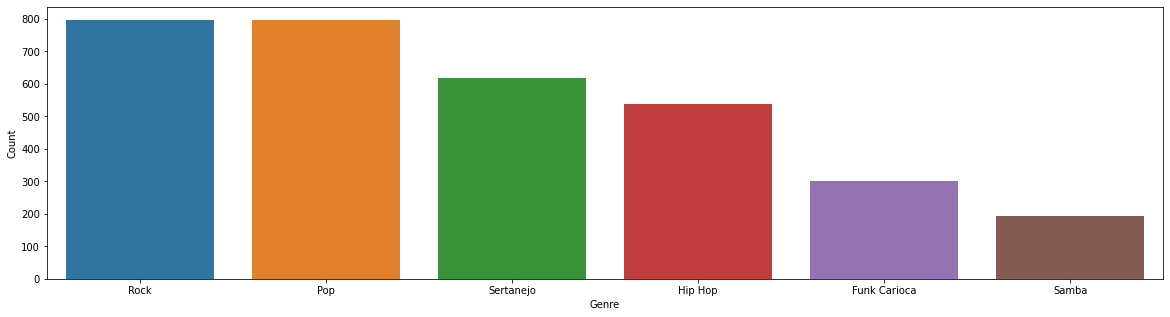

In [85]:
df=pd.DataFrame(artists.Genre.value_counts()).reset_index()
plt.figure(figsize=(20,5))
ax = sns.barplot(data=df, x= "index", y = "Genre")
ax.set(ylabel = 'Count', xlabel= 'Genre')
plt.show()

#### SongLyrics with Genre

In [86]:
#merge dataframe to get each lyric with the corresponding genre
#Note: some songs may appear more than once because classified with different genres 
songlyrics = pd.merge(lyrics, artists, how='inner', left_on='ALink', right_on='Link')
songlyrics = songlyrics.drop(['ALink','Link'], axis=1)
songlyrics.head()

,SName,Lyric,Artist,Genre
0,More Than This,I could feel at the time. There was no way of ...,10000 Maniacs,Rock
1,More Than This,I could feel at the time. There was no way of ...,10000 Maniacs,Pop
2,Because The Night,"Take me now, baby, here as I am. Hold me close...",10000 Maniacs,Rock
3,Because The Night,"Take me now, baby, here as I am. Hold me close...",10000 Maniacs,Pop
4,These Are Days,These are. These are days you'll remember. Nev...,10000 Maniacs,Rock


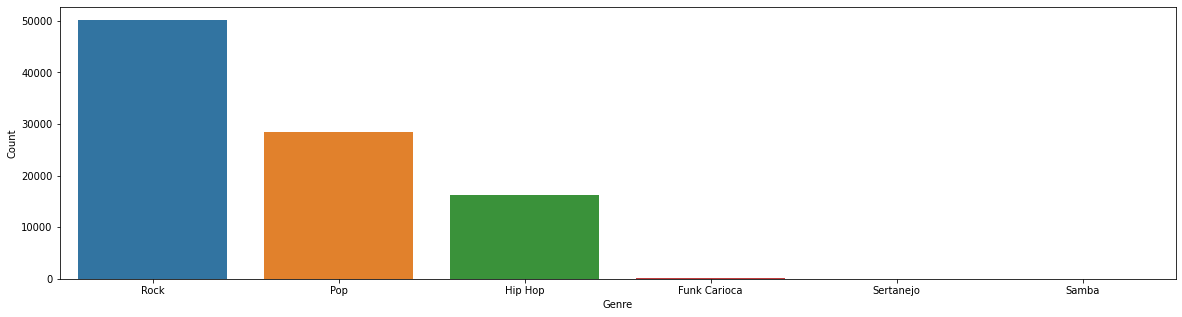

In [87]:
df=pd.DataFrame(songlyrics.Genre.value_counts()).reset_index()
plt.figure(figsize=(20,5))
ax = sns.barplot(data=df, x= "index", y = "Genre")
ax.set(ylabel = 'Count', xlabel= 'Genre')
plt.show()

In [88]:
songlyrics.Genre.value_counts()

Rock            50153
Pop             28436
Hip Hop         16143
Funk Carioca       69
Sertanejo          58
Samba              42
Name: Genre, dtype: int64

The number of songs for each Genre is reduced in the merged dataset since I have removed the songs that are not in English 

## **Classify songs**

In [89]:
songlyrics['preprocessed_lyric'] = songlyrics['Lyric'].apply(lambda text: contractions.fix(text))
songlyrics['preprocessed_lyric'] = songlyrics['preprocessed_lyric'].apply(lambda text: textPreProcessor(text))
songlyrics['preprocessed_lyric']= songlyrics['preprocessed_lyric'].apply(lambda text: tweetTokenizer.tokenize(text))
songlyrics['preprocessed_lyric']= songlyrics['preprocessed_lyric'].apply(lambda text: remove_punctuation(text))

In [90]:
emotions = model_xgb.predict(songlyrics['preprocessed_lyric']) #apply best classifier obtained in previous section 

In [91]:
songlyrics['predictedEmotion']= labelEncoder.inverse_transform(emotions)
songlyrics.drop(columns=['preprocessed_lyric'], inplace= True)

In [92]:
#drop songs that are instrumental, since they are meaningless for the purpose of this project
songlyrics = songlyrics.drop(songlyrics[songlyrics['Lyric'] =='[This song is an instrumental.].'].index)
songlyrics.head()

,SName,Lyric,Artist,Genre,predictedEmotion
0,More Than This,I could feel at the time. There was no way of ...,10000 Maniacs,Rock,fear
1,More Than This,I could feel at the time. There was no way of ...,10000 Maniacs,Pop,fear
2,Because The Night,"Take me now, baby, here as I am. Hold me close...",10000 Maniacs,Rock,anger
3,Because The Night,"Take me now, baby, here as I am. Hold me close...",10000 Maniacs,Pop,anger
4,These Are Days,These are. These are days you'll remember. Nev...,10000 Maniacs,Rock,joy


As specified above, in this dataset, songs can belong to more than one "Genre", therefore in the line below I remove duplicated lyrics and create a Genre label that contains all the Genre labels associated to the duplicated song: for example, in the table above record 0 and 1 are the same and differ only for the Genre, so I will keep just one record and set Genre equal to: {Rock, Pop}  

In [93]:
temp_df= songlyrics.copy()
temp_df.head()

,SName,Lyric,Artist,Genre,predictedEmotion
0,More Than This,I could feel at the time. There was no way of ...,10000 Maniacs,Rock,fear
1,More Than This,I could feel at the time. There was no way of ...,10000 Maniacs,Pop,fear
2,Because The Night,"Take me now, baby, here as I am. Hold me close...",10000 Maniacs,Rock,anger
3,Because The Night,"Take me now, baby, here as I am. Hold me close...",10000 Maniacs,Pop,anger
4,These Are Days,These are. These are days you'll remember. Nev...,10000 Maniacs,Rock,joy


In [94]:
temp_df.drop(columns=['Artist'], inplace=True)
temp_df.drop_duplicates(inplace=True)
songs = temp_df.groupby(['Lyric', 'SName']).agg({'Genre': ', '.join, 'predictedEmotion': 'first'}).reset_index()

In [95]:
songs.loc[songs['Genre'] == 'Pop, Rock', 'Genre'] = 'Rock, Pop'
songs.loc[songs['Genre'] == 'Pop, Hip Hop', 'Genre'] = 'Hip Hop, Pop'
songs.loc[songs['Genre'] == 'Hip Hop, Rock', 'Genre'] = 'Rock, Hip Hop'
songs.loc[songs['Genre'] == 'Funk Carioca, Pop', 'Genre'] = 'Pop, Funk Carioca'
songs.loc[songs['Genre'] == 'Samba, Rock', 'Genre'] = 'Rock, Samba'
songs.loc[songs['Genre'] == 'Sertanejo, Pop', 'Genre'] = 'Pop, Sertanejo'
songs.loc[songs['Genre'] == 'Rock, Sertanejo, Pop', 'Genre'] = 'Rock, Pop, Sertanejo'
songs.loc[songs['Genre'] == 'Rock, Pop, Hip Hop', 'Genre'] = 'Hip Hop, Pop, Rock'

In [96]:
songs.Genre.value_counts()

Rock                          45962
Pop                           21261
Hip Hop                       11795
Hip Hop, Pop                   3616
Rock, Pop                      3378
Rock, Hip Hop                   688
Pop, Funk Carioca                59
Sertanejo                        29
Samba                            25
Pop, Sertanejo                   16
Rock, Samba                      16
Rock, Sertanejo                   7
Funk Carioca                      6
Rock, Pop, Sertanejo              5
Funk Carioca, Hip Hop             2
Hip Hop, Pop, Rock                2
Sertanejo, Funk Carioca           1
Pop, Samba                        1
Funk Carioca, Hip Hop, Pop        1
Name: Genre, dtype: int64

## **Genre and Emotion relation**

### Cross Table

In [97]:
crosstable= pd.crosstab(songs['Genre'], songs['predictedEmotion'])
crosstable

predictedEmotion,anger,fear,joy,sadness
Genre,,,,
Funk Carioca,1,4,1,0
"Funk Carioca, Hip Hop",1,1,0,0
"Funk Carioca, Hip Hop, Pop",1,0,0,0
Hip Hop,2072,6009,1917,1797
"Hip Hop, Pop",591,2070,526,429
"Hip Hop, Pop, Rock",0,1,0,1
Pop,3384,11466,2919,3492
"Pop, Funk Carioca",8,35,6,10
"Pop, Samba",0,0,1,0


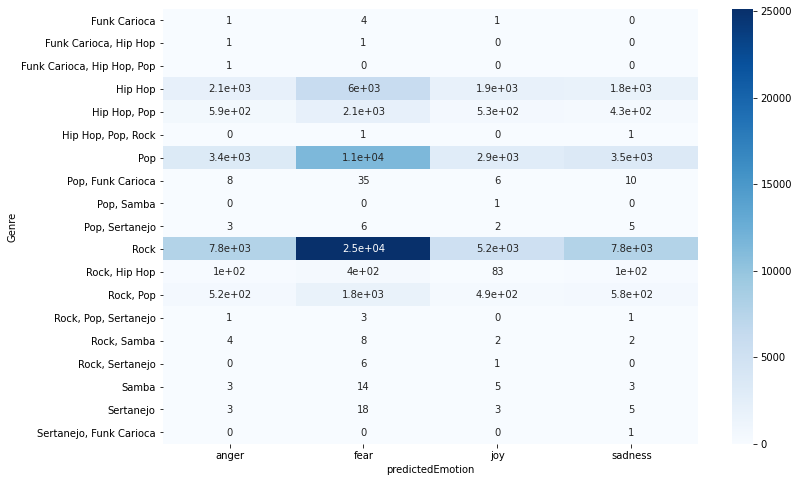

In [106]:
plt.figure(figsize=(12,8)) 
sns.heatmap(crosstable, annot=True, cmap="Blues")

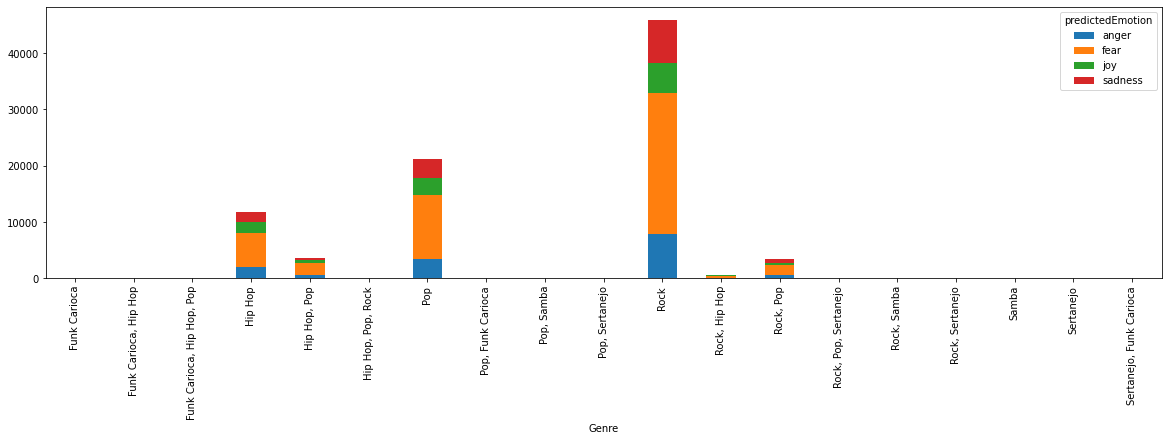

In [99]:
crosstable.plot(kind='bar', stacked= True, figsize= (20,5))

Looking at this graph it does not seem that there is any relation between the the emotion and the genre, it looks like the number of songs of each emotion class is proportional to the total number of songs for each genre. 

In [100]:
crosstable_reduced= pd.crosstab(songs['Genre'], songs['predictedEmotion'], margins= True, margins_name= 'TOT')
crosstable_reduced = crosstable_reduced.drop(crosstable_reduced[crosstable_reduced['TOT'] < 4000].index)
crosstable_reduced= crosstable_reduced.drop('TOT', axis=1)
crosstable_reduced= crosstable_reduced.drop('TOT', axis=0)
crosstable_reduced

predictedEmotion,anger,fear,joy,sadness
Genre,,,,
Hip Hop,2072,6009,1917,1797
Pop,3384,11466,2919,3492
Rock,7849,25119,5235,7759


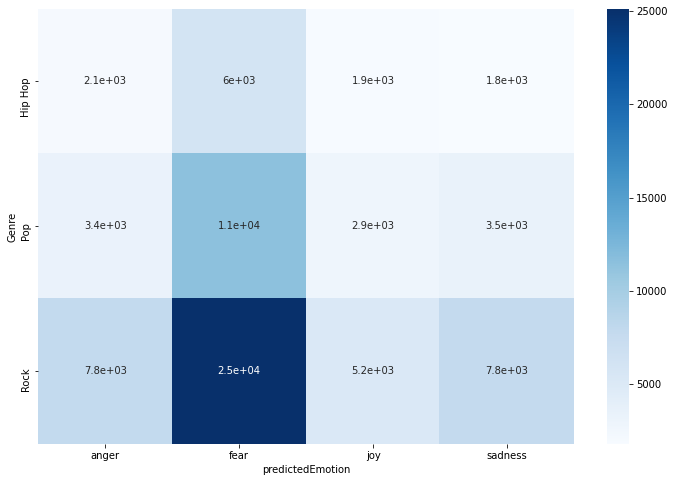

In [105]:
plt.figure(figsize=(12,8)) 
sns.heatmap(crosstable_reduced, annot=True, cmap="Blues")

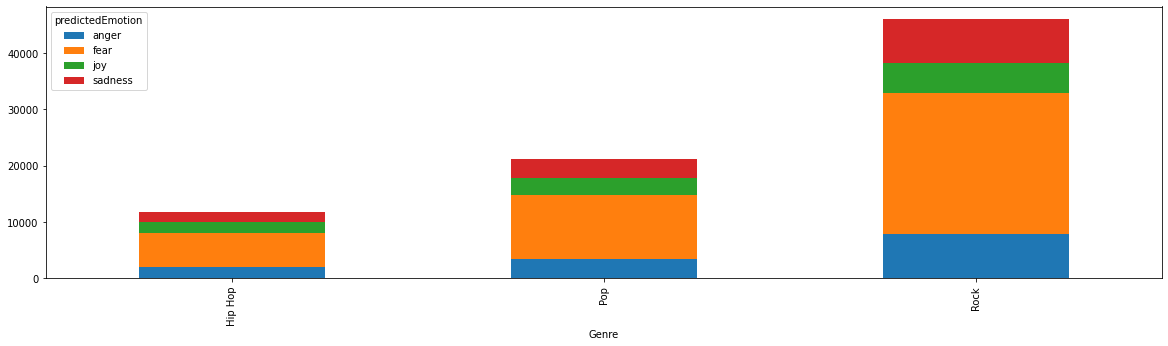

In [111]:
crosstable_reduced.plot(kind='bar', stacked= True, figsize= (20,5))

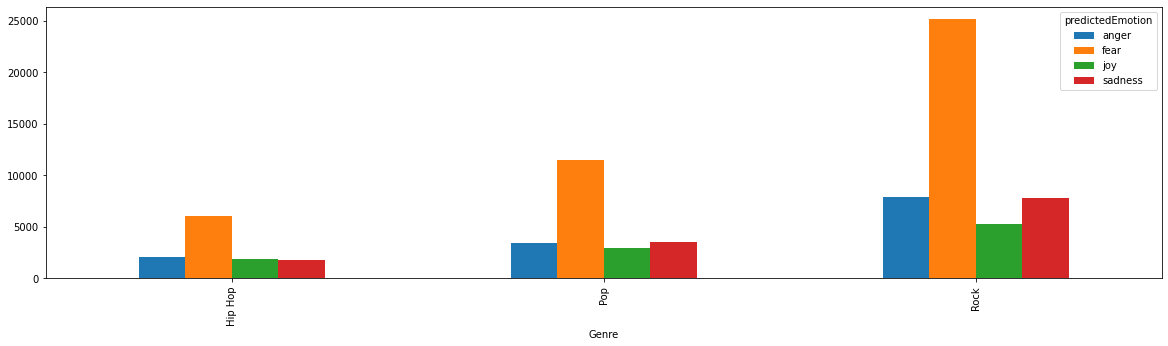

In [112]:
crosstable_reduced.plot(kind='bar', figsize= (20,5))

This graph shows only the most popular genres and it seems that there are no emotion more related to a specific genere than another. The number of songs for each emotion seems to be proportional to the number of songs for the genre.
In the section below I employ statistical tests to understand if truly Genre and Emotion are independent  

### Statistical tests

##### Pearson's Chi-Square test
This test of independence assesses whether observations consisting of measures on two variables, expressed in a cross table, are independent of each other, in this case if Genre is independent of Emotion, in statistical terms I test the null hypothesis: <br>
**H0: Genre and Emotion are independent**

In [114]:
c, p, dof, expected = ss.chi2_contingency(crosstable) 
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

Dependent (reject H0)


The Chi-Square test rejects the null hypothesis, thus suggesting that there might be a dependence between the two variables, however this could be due to the fact that a weak association in a large sample size may also result in p = 0.000. Therefore, in order to test how strong this dependence is I employ the Cramér's V test, that returns a number between 0 and 1 that indicates how strongly two categorical variables are associated and it is based on Pearson's chi-squared statistic. 

##### Cramer's V test

In [118]:
def cramersVtest(crosstable):
    confusion_matrix = crosstable
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    result= np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    if result < 0.3:
      print("Weak association since values is: ", round(result,3))
    if result >= 0.3 and result < 0.6:
      print ("Mild association since values is: ", round(result,3))
    if result >= 0.6:
      print("Strong association since values is: ", round(result,3))

cramersVtest(crosstable)

Weak association since values is:  0.035


The Cramer'V test confirms the result that could be obtained interpeting the graphs above and therefore that there is a very weak association between the two variables.

## **PlayList**
Based on the mood of the user and on the favorite genre, I suggest a list of songs to enjoy

In [120]:
joy = ['cheearful', 'content', 'proud', 'relieved', 'optimist', 'joyful', 'loved', 'enthusiast','happy']
anger = ['irritable', 'tormented', 'envious', 'exasperated', 'mad', 'enraged', 'displeased', 'disgusted','angry']
sadness = ['sad', 'suffering', 'disappointed', 'ashamed', 'neglected', 'alone', 'lost']
fear = ['scared', 'fear', 'nervous', 'frightened', 'afraid', 'fearful']

print("Hello there! ")
emotion = None
while(emotion== None):
  user_emotion = input("How are you feeling today?")
  if user_emotion in joy:
    emotion= 'joy'
    print('Wow, looks like you are feeling good today, let\'s find the right songs :)')
  elif user_emotion in anger:
    emotion = 'anger'
    print('Mm... sounds like you are mad today, I am going to find the perfect song to vent')
  elif user_emotion in fear:
    emotion = 'fear'
    print('Ohh, sorry to hear that you are scared, do not worry, everthing will be fine, in the mean time listen to some good music')
  elif user_emotion in sadness:
    emotion = 'sadness'
    print('Sorry about that, let\'s find songs to relieve your pain')
  else:
    print('Looks like this feeling does not exist, try again')

print("What music genre would you prefer?")
genre = input("Choose one between: Rock, Pop, Hip Hop, Funk Carioca, Sertanejo, Samba: ")

print("Well done! here is a list of songs selected for you, enjoy!")
df = songlyrics[(songlyrics['Genre'] == genre) & (songlyrics['predictedEmotion'] == emotion)].copy()
df.drop(columns=['Lyric', 'Genre', 'predictedEmotion'], inplace= True)
df = df.sample(frac=1)
df.head(15)

Hello there! 
How are you feeling today?proud
Wow, looks like you are feeling good today, let's find the right songs :)
What music genre would you prefer?
Choose one between: Rock, Pop, Hip Hop, Funk Carioca, Sertanejo, Samba: Pop
Well done! here is a list of songs selected for you, enjoy!


,SName,Artist
85275,Super Bowl 2012 Half Time Show,Madonna
90973,Truth or Dare (On The Dancefloor),Shakira
73361,The Gate,Belle & Sebastian
84859,Only Gets Better,Maddi Jane
55512,Back Out,Chris Brown
75742,Makes Me Wanna Pray (feat. Steve Winwood),Christina Aguilera
90949,Long Time,Shakira
93523,Where Or When,The Supremes
84552,Winter Wonderland,Leona Lewis
74765,You Can do (Whatever),Cat Stevens
